<a href="https://colab.research.google.com/github/wesley28/ProcessamentoDigitalDeImagens/blob/main/10)_Realce_por_manipula%C3%A7%C3%A3o_de_Histogramas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import math
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_theme(style="darkgrid")


class ImagemBPM:

  def __init__(self, tipo='', largura=0, altura=0, valor_maximo = 1, colorido=False):
    self.tipo = tipo
    self.largura = largura
    self.altura = altura
    self.valor_maximo = valor_maximo
    self.colorido = colorido


  def _read(self, path):
    return open(path, "r").read().split('\n')


  def extrair_imagem(self, path, default_rgb = 0):
    ls_imagem = self._read(path)

    if self.colorido:
      self.tipo = ls_imagem[0]
      self.largura = int(ls_imagem[2].split()[0])
      self.altura = int(ls_imagem[2].split()[1])
      self.valor_maximo = int(ls_imagem[3])

      conteudo = ls_imagem[5:]
      conteudo = [i.split(' ') for i in conteudo]
      np_conteudo = np.array(conteudo)
      np_conteudo = np.concatenate(np_conteudo)
      np_conteudo = np.delete(np_conteudo, np.where(np_conteudo == ''))
      self.conteudo = [int(i) for i in np_conteudo]

      lista_rgb = {
          'red': np.array([]),
          'green': np.array([]),
          'blue': np.array([])
      }

      lista_rgb['red'] = np.array([self.conteudo[i] if i % 3 == 0 else default_rgb for i in range(len(self.conteudo))])
      lista_rgb['green'] = np.array([self.conteudo[i] if i % 3 == 1 else default_rgb for i in range(len(self.conteudo))])
      lista_rgb['blue'] = np.array([self.conteudo[i] if i % 3 == 2 else default_rgb for i in range(len(self.conteudo))])
      self.lista_rgb = lista_rgb

      lista_rgb_hist = {
          'red': np.array([]),
          'green': np.array([]),
          'blue': np.array([])
      }

      lista_rgb_hist['red'] = np.array([self.conteudo[i] for i in range(len(self.conteudo)) if i % 3 == 0])
      lista_rgb_hist['green'] = np.array([self.conteudo[i] for i in range(len(self.conteudo)) if i % 3 == 1]) # 1:0 4:1 7:2 10:3   1 3 5 7     i div 3
      lista_rgb_hist['blue'] = np.array([self.conteudo[i] for i in range(len(self.conteudo)) if i % 3 == 2])  # 2:0 5:1 8:2 11:3   1 3 5 7     i div 3
      self.lista_rgb_hist = lista_rgb_hist
      self.conteudo = np.array(self.conteudo)

    else:
      self.tipo = ls_imagem[0]
      self.largura = int(ls_imagem[1].split()[0])
      self.altura = int(ls_imagem[1].split()[1])
      self.valor_maximo = int(ls_imagem[2])
      self.conteudo = np.array([int(i) if i != '' else 0 for i in ls_imagem[2 : self.altura * self.largura + 2]])


  def gerar_hist(self, nome_arquivo, rgb=None):
    if rgb is None:
      self._hist(pd.Series(self.conteudo), nome_arquivo)

    else:
      self._hist(pd.Series(self.lista_rgb_hist[rgb]), nome_arquivo+'_'+rgb, rgb)


  def _hist(self, df, nome_arquivo, cor='gray'):
    ax = df.hist(color = cor)
    fig = ax.get_figure()
    fig.savefig(nome_arquivo+'.jpg')


  def transformacao_linear(self, escala_cinza=True):

    if escala_cinza:
      self.conteudo_tranformacao_linear = self._transformacao_linear(self.conteudo)

    else:
      conteudo_tranformacao_linear_red = self._transformacao_linear(self.lista_rgb_hist['red'])
      conteudo_tranformacao_linear_green = self._transformacao_linear(self.lista_rgb_hist['green'])
      conteudo_tranformacao_linear_blue = self._transformacao_linear(self.lista_rgb_hist['blue'])

      lt_conteudo_rgb_transformacao_linear = []
      for i in range(len(conteudo_tranformacao_linear_red) * 3):
        if i % 3 == 1:
          lt_conteudo_rgb_transformacao_linear.append(conteudo_tranformacao_linear_green[i // 3])
        elif i % 3 == 2:
          lt_conteudo_rgb_transformacao_linear.append(conteudo_tranformacao_linear_blue[i // 3])
        else:
          lt_conteudo_rgb_transformacao_linear.append(conteudo_tranformacao_linear_red[i // 3])
      self.conteudo_tranformacao_linear = np.array(lt_conteudo_rgb_transformacao_linear)

  def _transformacao_linear(self, valores):
    min_valor = min(valores)
    max_valor = max(valores)
    self.a = 255 / (max_valor - min_valor) # Y = x * a + b
    self.b = -self.a * min_valor

    lt_conteudo_tranformacao_linear = []
    for vlr in self._gen_transformacao_linear(valores):
      lt_conteudo_tranformacao_linear.append(vlr)
    return np.array(lt_conteudo_tranformacao_linear)


  def _gen_transformacao_linear(self, valores):
    for vlr in valores:
      yield round(self.a * vlr + self.b)

  def _gerar_cabecalho(self):
    return '{}\n{} {}\n {}\n'.format(self.tipo, self.largura, self.altura, self.valor_maximo)


  def salvar_imagem(self, nome, formato):
    with open('{}.{}'.format(nome, formato), 'w') as fd:
      fd.write(self.imagem)


  def salvar_imagem_rgb(self, nome, formato):
    with open('{}.{}'.format(nome+'_red', formato), 'w') as fd:
      fd.write(self.imagem_red)

    with open('{}.{}'.format(nome+'_green', formato), 'w') as fd:
      fd.write(self.imagem_green)

    with open('{}.{}'.format(nome+'_blue', formato), 'w') as fd:
      fd.write(self.imagem_blue)


  def gerar_imagem(
      self, colorido = False, random = True,gerar_rgb = False, media_escala_cinza = False,
      media_rgb=False, transformacao_linear=False):

    if random:
      cabecalho = self._gerar_cabecalho()
      matriz = '\n'.join([' '.join([str(random.randint(0, self.valor_maximo)) for _ in range(self.altura * 3 if colorido else self.altura)]) for _ in range(self.largura)])
      self.imagem = cabecalho + matriz

    elif gerar_rgb:
      self.imagem_red = '{}\n{} {}\n{}\n{}'.format(
          self.tipo, self.largura, self.altura, self.valor_maximo,
          '\n'.join([str(i) for i in self.lista_rgb['red'].tolist()]))
      self.imagem_green = '{}\n{} {}\n{}\n{}'.format(
          self.tipo, self.largura, self.altura, self.valor_maximo,
          '\n'.join([str(i) for i in self.lista_rgb['green'].tolist()]))
      self.imagem_blue = '{}\n{} {}\n{}\n{}'.format(
          self.tipo, self.largura, self.altura, self.valor_maximo,
          '\n'.join([str(i) for i in self.lista_rgb['blue'].tolist()]))

    elif transformacao_linear:
      self.imagem = '{}\n{} {}\n{}\n{}'.format(
          self.tipo, self.largura, self.altura, self.valor_maximo,
          '\n'.join([str(i) for i in self.conteudo_tranformacao_linear.tolist()]))

    else:
      self.imagem = '{}\n{} {}\n{}'.format(
          self.tipo, self.largura, self.altura,
          '\n'.join([str(i) for i in self.conteudo.tolist()]))


## Histogramas

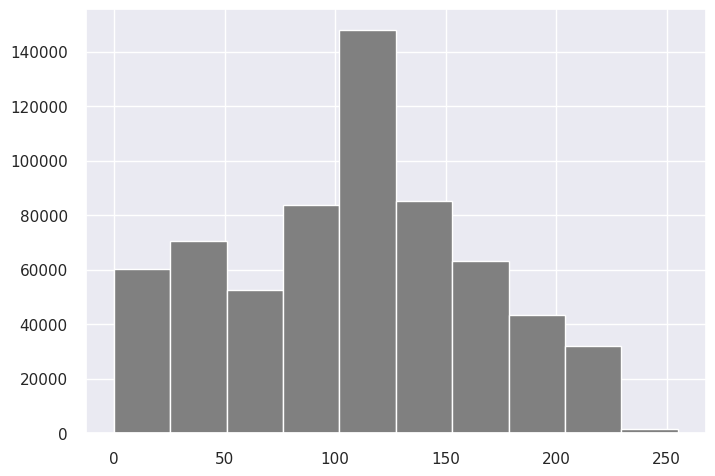

In [13]:
t1 = ImagemBPM()
t1.extrair_imagem("/content/escala_cinza_transformacao_linear.txt")
t1.gerar_hist('escala_cinza')

<ipython-input-1-fb64d1cee72b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_conteudo = np.array(conteudo)


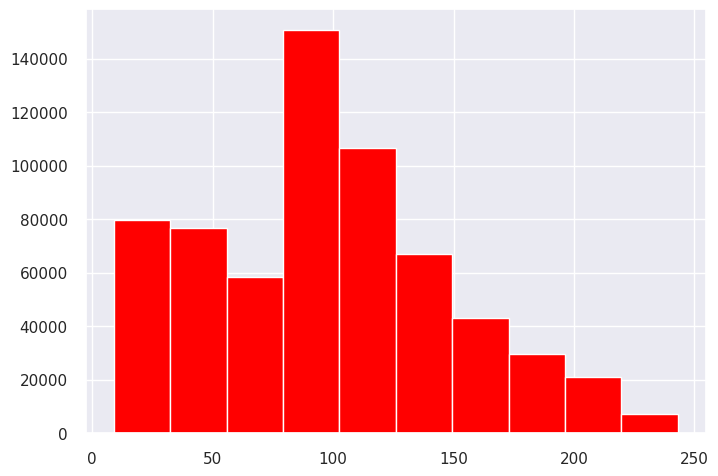

In [18]:
t1 = ImagemBPM(colorido=True)
t1.extrair_imagem("/content/entrada_rgb_transformacao_linear.txt")
t1.gerar_hist('rgb', rgb='red')

In [ ]:
t1.gerar_hist('rgb', rgb='green')

In [ ]:
t1.gerar_hist('rgb', rgb='blue')

In [2]:
t1 = ImagemBPM()
t1.extrair_imagem("/content/Entrada_EscalaCinza.txt")
t1.transformacao_linear()
t1.gerar_imagem(random=False, transformacao_linear=True)
t1.salvar_imagem('escala_cinza_transformacao_linear', 'pgm')

In [ ]:
t1 = ImagemBPM(colorido=True)
t1.extrair_imagem("/content/EntradaRGB.txt")
t1.transformacao_linear(escala_cinza=False)
t1.gerar_imagem(random=False, transformacao_linear=True)
t1.salvar_imagem('entrada_rgb_transformacao_linear', 'pgm')

In [4]:
len(t1.conteudo_tranformacao_linear)

1920000

In [5]:
min_valor = min(t1.conteudo)
max_valor = max(t1.conteudo)
# max 255    min 13     y = aX + b   conteudo_tranformacao_linear
a = 255 / (max_valor - min_valor)
b = -a * min_valor
a, b


(1.0365853658536586, -9.329268292682928)